In [ ]:
#import rasterio
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
#import cvnn
#import cvnn.layers as complex_layers <- update tf

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
print(os.getcwd())
os.chdir(r'/content/gdrive/MyDrive/Trial/Real')
print(os.getcwd())

Mounted at /content/gdrive
/content
/content/gdrive/MyDrive/Trial/Real


In [ ]:
#numpy.random.seed(43)

In [ ]:
# Set parameters
patch_size = 256
n_bands = 3
n_bands1 = 2
n_bands2 = 4
n_classes = 2
batch_size = 10
epochs = 50

In [ ]:
x = np.load("Patches/x.npy")
y = np.load("Patches/y.npy")

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.3, random_state=38)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=38)

In [ ]:
del x
del y

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(1161, 256, 256, 3)
(1161, 256, 256, 1)
(554, 256, 256, 3)
(554, 256, 256, 1)
(130, 256, 256, 3)
(130, 256, 256, 1)


In [ ]:
#for binary, add num_classes=None, dtype='float32'), classes=max(y)+1

train_y_1hot = tf.keras.utils.to_categorical(train_y)#, num_classes=None, dtype='float32')
val_y_1hot = tf.keras.utils.to_categorical(val_y)#, num_classes=None, dtype='float32')
test_y_1hot = tf.keras.utils.to_categorical(test_y)#, num_classes=None, dtype='float32')

train_y_1hot.shape

(1161, 256, 256, 2)

### **Build Model**

In [ ]:
# BN_CONV_ReLU,Pool: Biswas. #CONV_BN_ReLU,Pool: Chibber. #CONV_BN_ReLU,CONV_BN_ReLU,Dropout,Pool: Practical
# conv1 = tf.keras.layers.Conv2D(n_filters=64, kernel_size=3, dilation_rate=1, activation='relu', padding='same')
# https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
def get_model(patch_size, n_bands, n_classes):
    inputs = tf.keras.Input(shape=(patch_size, patch_size, n_bands))

    # ENCODER
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.LeakyReLU()(conv4)
    conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.LeakyReLU()(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv4)

    # BOTTOM
    conv5 = tf.keras.layers.Conv2D(1024, 3, padding='same')(pool4)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.LeakyReLU()(conv5)
    conv5 = tf.keras.layers.Conv2D(1024, 3, padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.LeakyReLU()(conv5)

    # DECODER
    # BN_Conv2DTranspose_LeakyReLU: Biswas. #Upsampling2D_Conv2DTranspose_BN_LeakyReLU: Chibber. #Upsamling2D_CONV_BN_LeakyReLU: Practical
    # deconv = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides)

    deconv4 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2,2), padding='same')(conv5)
    merge4 = tf.keras.layers.concatenate([conv4, deconv4]) #order, axis=3
    uconv4 = tf.keras.layers.BatchNormalization()(merge4)
    uconv4 = tf.keras.layers.LeakyReLU()(uconv4)
    uconv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(uconv4)
    uconv4 = tf.keras.layers.BatchNormalization()(uconv4)
    uconv4 = tf.keras.layers.LeakyReLU()(uconv4)
    uconv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(uconv4)
    uconv4 = tf.keras.layers.BatchNormalization()(uconv4)
    uconv4 = tf.keras.layers.LeakyReLU()(uconv4)

    deconv3 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same')(uconv4)
    merge3 = tf.keras.layers.concatenate([conv3, deconv3])
    uconv3 = tf.keras.layers.BatchNormalization()(merge3)
    uconv3 = tf.keras.layers.LeakyReLU()(uconv3)
    uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(uconv3)
    uconv3 = tf.keras.layers.BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.LeakyReLU()(uconv3)
    uconv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(uconv3)
    uconv3 = tf.keras.layers.BatchNormalization()(uconv3)
    uconv3 = tf.keras.layers.LeakyReLU()(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same')(uconv3)
    merge2 = tf.keras.layers.concatenate([conv2, deconv2])
    uconv2 = tf.keras.layers.BatchNormalization()(merge2)
    uconv2 = tf.keras.layers.LeakyReLU()(uconv2)
    uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(uconv2)
    uconv2 = tf.keras.layers.BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.LeakyReLU()(uconv2)
    uconv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(uconv2)
    uconv2 = tf.keras.layers.BatchNormalization()(uconv2)
    uconv2 = tf.keras.layers.LeakyReLU()(uconv2)

    deconv1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same')(uconv2)
    merge1 = tf.keras.layers.concatenate([conv1, deconv1])
    uconv1 = tf.keras.layers.BatchNormalization()(merge1)
    uconv1 = tf.keras.layers.LeakyReLU()(uconv1)
    uconv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(uconv1)
    uconv1 = tf.keras.layers.BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.LeakyReLU()(uconv1)
    uconv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(uconv1)
    uconv1 = tf.keras.layers.BatchNormalization()(uconv1)
    uconv1 = tf.keras.layers.LeakyReLU()(uconv1)

    outputs = tf.keras.layers.Conv2D(n_classes, 1, activation="softmax")(uconv1)

    return tf.keras.Model(inputs, outputs)

In [ ]:
model = get_model(patch_size, n_bands, n_classes) # Get model

# Compile as any Tensorflow model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), metrics=['accuracy'])#tf.keras.metrics.MeanIoU(num_classes=n_classes))#metrics

model.summary()

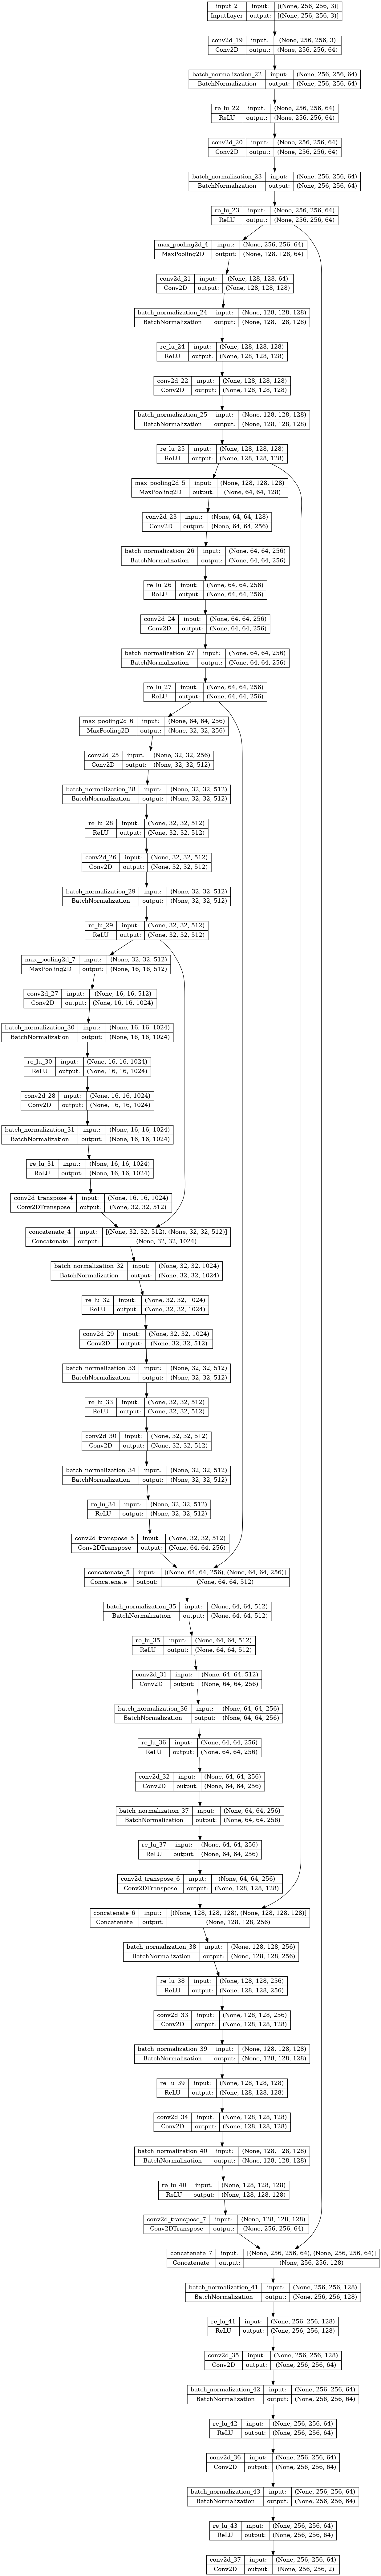

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training

In [ ]:
# Define callbacks parameters
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='Output/models2.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
# Train and evaluate (catcross), lr 1e-5, metric=accuracy
history = model.fit(train_x, train_y_1hot, batch_size=batch_size, epochs=epochs, #validaion_split:0.2,
                    validation_data=(val_x, val_y_1hot), callbacks=my_callbacks, verbose=1)

Epoch 1/50
117/117 [==============================] - 142s 914ms/step - loss: 0.3283 - accuracy: 0.8668 - val_loss: 0.6743 - val_accuracy: 0.5823
Epoch 2/50
117/117 [==============================] - 108s 920ms/step - loss: 0.2307 - accuracy: 0.9096 - val_loss: 0.6406 - val_accuracy: 0.5831
Epoch 3/50
117/117 [==============================] - 101s 864ms/step - loss: 0.2121 - accuracy: 0.9167 - val_loss: 0.5394 - val_accuracy: 0.6849
Epoch 4/50
117/117 [==============================] - 107s 919ms/step - loss: 0.2084 - accuracy: 0.9192 - val_loss: 0.4242 - val_accuracy: 0.8258
Epoch 5/50
117/117 [==============================] - 108s 922ms/step - loss: 0.1932 - accuracy: 0.9245 - val_loss: 0.2484 - val_accuracy: 0.9188
Epoch 6/50
117/117 [==============================] - 108s 923ms/step - loss: 0.1886 - accuracy: 0.9266 - val_loss: 0.1812 - val_accuracy: 0.9393
Epoch 7/50
117/117 [==============================] - 108s 925ms/step - loss: 0.1985 - accuracy: 0.9235 - val_loss: 0.1489 -

In [ ]:
# Train and evaluate: lr  1e-5, metric=accuracy
history = model.fit(train_x, train_y_1hot, batch_size=batch_size, epochs=epochs, #validation_split:0.2,
                    validation_data=(val_x, val_y_1hot), callbacks=my_callbacks, verbose=1)

Epoch 1/50
117/117 [==============================] - 66s 469ms/step - loss: 0.3374 - accuracy: 0.8540 - val_loss: 0.6752 - val_accuracy: 0.5820
Epoch 2/50
117/117 [==============================] - 52s 447ms/step - loss: 0.2140 - accuracy: 0.9147 - val_loss: 0.6488 - val_accuracy: 0.5838
Epoch 3/50
117/117 [==============================] - 48s 409ms/step - loss: 0.2170 - accuracy: 0.9135 - val_loss: 0.5527 - val_accuracy: 0.8084
Epoch 4/50
117/117 [==============================] - 52s 445ms/step - loss: 0.1970 - accuracy: 0.9224 - val_loss: 0.3667 - val_accuracy: 0.8956
Epoch 5/50
117/117 [==============================] - 53s 451ms/step - loss: 0.1884 - accuracy: 0.9255 - val_loss: 0.2685 - val_accuracy: 0.9025
Epoch 6/50
117/117 [==============================] - 52s 444ms/step - loss: 0.1881 - accuracy: 0.9249 - val_loss: 0.2365 - val_accuracy: 0.9290
Epoch 7/50
117/117 [==============================] - 47s 405ms/step - loss: 0.1796 - accuracy: 0.9295 - val_loss: 0.1538 - val_ac

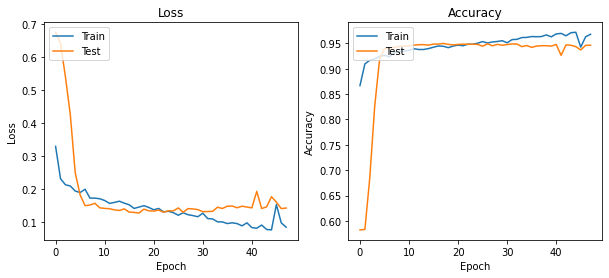

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

#plt.tight_layout()
plt.show()

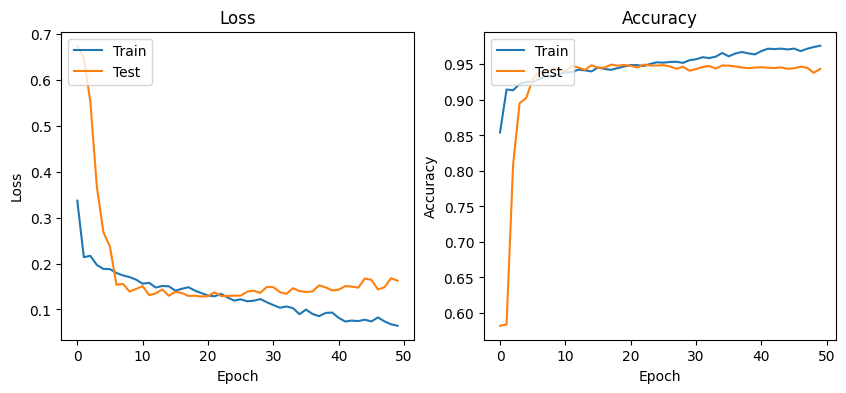

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

#plt.tight_layout()
plt.show()

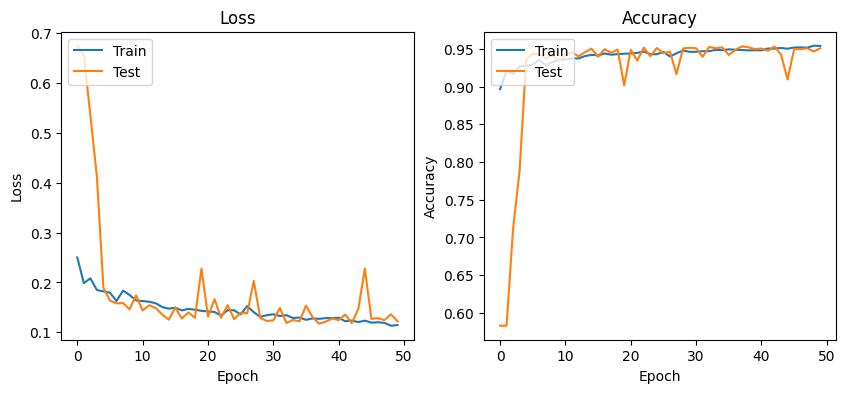

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# accuracy
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

#plt.tight_layout()
plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(val_x, val_y_1hot)#, batch_size=20)
print(f"\nValidation accuracy of U-Net: {100 * val_acc:.2f}%")

18/18 [==============================] - 21s 640ms/step - loss: 0.1265 - accuracy: 0.9499

Validation accuracy of U-Net: 94.99%


In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y_1hot)#, batch_size=15)
print(f"\nValidation accuracy of U-Net: {100 * test_acc:.2f}%")

5/5 [==============================] - 5s 1s/step - loss: 0.1390 - accuracy: 0.9444

Validation accuracy of U-Net: 94.44%


In [ ]:
# https://stackoverflow.com/questions/51854463/is-it-possible-to-retrain-a-previously-saved-keras-model
model.save("Output/unetsef_lr1e-5.h5")
#model.save_weights("unet_weights.h5")

## Apply on random patches

1/1 [==============================] - 0s 23ms/step


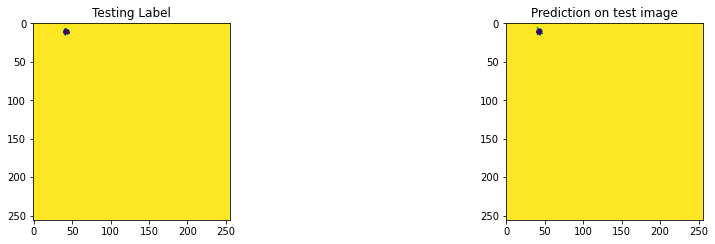

In [ ]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(test_x))
test_img = test_x[test_img_number]
ground_truth=test_y[test_img_number]
#ground_truth=test_y_1hot[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(
    12, 8))
plt.subplot(231)
#plt.title('Testing Image')
#plt.imshow(test_img)
#plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()